In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.signal import correlate2d, correlate

In [2]:
# helper function for visualization
def box_off():
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [3]:
# # stim pixel size
# height=13
# width=13
# pixel_size = 132 #um

height=26
width=26
pixel_size = 66 #um

## Gaussian stim

1.001097036561266


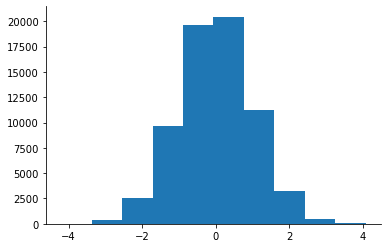

In [4]:
num_frames = 100
stim = np.random.randn(height,width, num_frames)
# stim = stim - np.mean(stim.ravel())

print(np.std(stim.ravel()))

plt.hist(stim.ravel())
box_off()

Text(0.5, 1.0, 'stimulus (26x26, pixel size=66 um)')

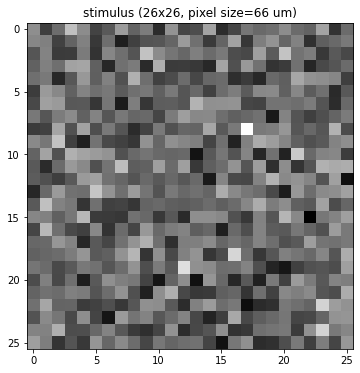

In [5]:
idx_frame = int(num_frames/2)
plt.figure(figsize=(18,6))

plt.imshow(stim[:,:,idx_frame], cmap='gray')
plt.title('stimulus ({:d}x{:d}, pixel size={:2} um)'.format(width,height,pixel_size))

# plt.savefig('figure/stim_{}x{}_gauss.png'.format(width,height), bbox_inches='tight')

### Smoothed Gaussian

0.3014696186341156


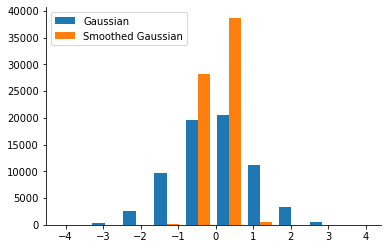

In [6]:
sigma = 1
# smoothe each frame

stim_spatial_smoothed = np.zeros((height,width,num_frames))
for n in range(num_frames):
    stim_spatial_smoothed[:,:,n] = gaussian_filter(stim[:,:,n], sigma=sigma)

print(np.std(stim_spatial_smoothed.ravel()))

plt.hist([stim.ravel(), stim_spatial_smoothed.ravel()])
plt.legend(['Gaussian', 'Smoothed Gaussian'])
box_off()

Text(0.5, 1.0, 'stimulus (26x26, pixel size=66 um)')

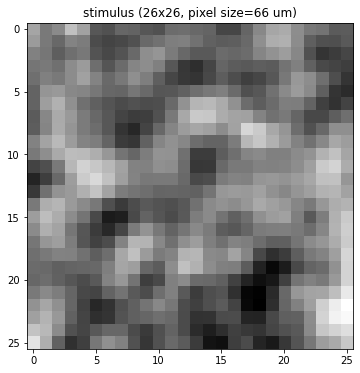

In [7]:
idx_frame = int(num_frames/2)
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.imshow(stim_spatial_smoothed[:,:,idx_frame], cmap='gray')
plt.title('stimulus ({:d}x{:d}, pixel size={:2} um)'.format(width,height,pixel_size))

# plt.savefig('figure/stim_{}x{}_gauss_smoothed.png'.format(width,height), bbox_inches='tight')

## related alpha with time const

$\alpha^t  =  \exp(- t / \tau).$
This means 
$\alpha = \exp(-\frac{1}{\tau}).$
$\tau = -\frac{1}{\log \alpha}.$

In [8]:
# decrease in one tau
np.exp(-1)

0.36787944117144233

In [9]:
# tau -> alpha
tau = 3
alpha = np.exp(-1 / tau) 
print(alpha)

0.7165313105737893


In [10]:
# alpha -> tau
tau = -1 / np.log(alpha)
tau

3.0

## Temporal smoothing

In [11]:
def smoothe_temp(trace, weight_prev):
    trace_smoothed = trace.copy()

    for t in range(len(trace)):
        if t == 0: # for the first time step, just copy
            continue
        
        trace_smoothed[t] = weight_prev * trace_smoothed[t-1] + (1-weight_prev) * trace_smoothed[t]   # mix with the previous time step
    return trace_smoothed
        
    
# reshape for processing each pixel
stim_spatial_smoothed = stim_spatial_smoothed.reshape((-1, num_frames))
stim_spatial_smoothed.shape

stim_temp_smoothed = np.zeros((height*width, num_frames))
for xy in range(height*width):    

    stim_temp_smoothed[xy,:] = smoothe_temp(stim_spatial_smoothed[xy,:], alpha)

# reshape back to original shapes
stim_spatial_smoothed = stim_spatial_smoothed.reshape((height, width, num_frames))
stim_temp_smoothed = stim_temp_smoothed.reshape((height, width, num_frames))    

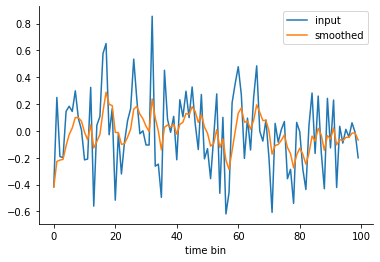

In [12]:
# compare traces for a pixel
x = 13
y = 13
plt.plot(stim_spatial_smoothed[y,x,:])
plt.plot(stim_temp_smoothed[y,x,:])
plt.xlabel('time bin')
plt.legend(['input', 'smoothed'])
box_off()

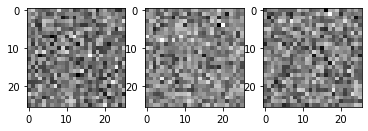

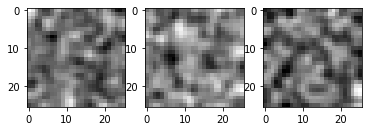

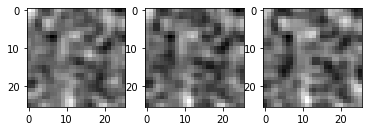

In [13]:
plt.subplot(131)
plt.imshow(stim[:,:,0], cmap='gray')
plt.subplot(132)
plt.imshow(stim[:,:,1], cmap='gray')
plt.subplot(133)
plt.imshow(stim[:,:,2], cmap='gray')

plt.figure()
plt.subplot(131)
plt.imshow(stim_spatial_smoothed[:,:,0], cmap='gray')
plt.subplot(132)
plt.imshow(stim_spatial_smoothed[:,:,1], cmap='gray')
plt.subplot(133)
plt.imshow(stim_spatial_smoothed[:,:,2], cmap='gray')

plt.figure()
plt.subplot(131)
plt.imshow(stim_temp_smoothed[:,:,0], cmap='gray')
plt.subplot(132)
plt.imshow(stim_temp_smoothed[:,:,1], cmap='gray')
plt.subplot(133)
plt.imshow(stim_temp_smoothed[:,:,2], cmap='gray')

(1.001097036561266, 0.3014696186341156, 0.12510415943956796)

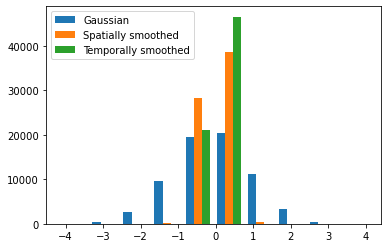

In [14]:
plt.hist([stim.ravel(), stim_spatial_smoothed.ravel(), stim_temp_smoothed.ravel()])
plt.legend(['Gaussian', 'Spatially smoothed', 'Temporally smoothed'])

np.std(stim.ravel()), np.std(stim_spatial_smoothed.ravel()), np.std(stim_temp_smoothed.ravel())

Text(0.5, 0, 'time bin')

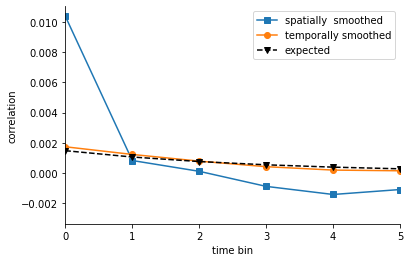

In [15]:
# check temopral correlation
x=20
y=20
corr = correlate(stim[y,x,:], stim[y,x,:]) / width /height

corr_spatial_smoothed = correlate(stim_spatial_smoothed[y,x,:], stim_spatial_smoothed[y,x,:]) / width /height

corr_temp_smoothed = correlate(stim_temp_smoothed[y,x,:], stim_temp_smoothed[y,x,:]) / width /height

corr_expected = alpha**(np.linspace(0, 10, 11)) / width / height

ts = np.linspace(-(num_frames-1),num_frames-1, 2*num_frames-1)
plt.plot(ts, corr_spatial_smoothed, 's-')
plt.plot(ts, corr_temp_smoothed, 'o-')
plt.plot(np.linspace(0, 10, 11), corr_expected, 'kv--')
plt.xlim(0,5)
plt.legend(['spatially  smoothed', 'temporally smoothed', 'expected'])
box_off()
plt.ylabel('correlation')
plt.xlabel('time bin')

Text(0.5, 1.0, 'stimulus (26x26, pixel size=66 um)')

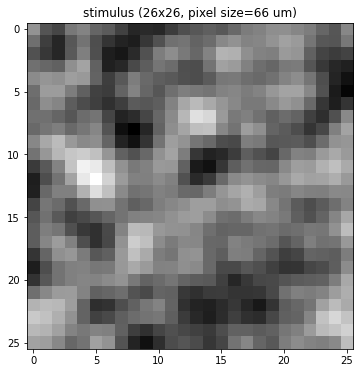

In [16]:
idx_frame = int(num_frames/2)
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.imshow(stim_temp_smoothed[:,:,idx_frame], cmap='gray')
plt.title('stimulus ({:d}x{:d}, pixel size={:2} um)'.format(width,height,pixel_size))

# plt.savefig('figure/stim_{}x{}_gauss_smoothed.png'.format(width,height), bbox_inches='tight')